Importing Libraries

In [89]:
import os
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re
import glob

from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization, Dropout, Dense, Flatten
from keras.callbacks import Callback, EarlyStopping

Importing Dataset

In [90]:
!pip install kaggle
!mkdir ~/.kaggle
!echo '{"username":"anoudalfaydi","key":"fa3fb761694ee5e822bc738afd23861a"}' > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d rashwan/arabic-chars-mnist

mkdir: cannot create directory ‘/root/.kaggle’: File exists
Dataset URL: https://www.kaggle.com/datasets/rashwan/arabic-chars-mnist
License(s): CC0-1.0
arabic-chars-mnist.zip: Skipping, found more recently modified local copy (use --force to force download)


In [91]:
import zipfile

zip_path = '/content/arabic-chars-mnist.zip'

target_directory = '/content/dataset'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(target_directory)

dataset = target_directory

In [92]:
train_data = '/content/dataset/train'
test_data = '/content/dataset/test'
train_images = [train_data+i for i in os.listdir(train_data)]
test_images = [test_data+i for i in os.listdir(test_data)]

In [93]:
# getting names of the images train
path_label_train = []
path_label_test = []
for filename in glob.glob('/content/dataset/train/*.jpg'):
    parts = re.split('/', filename)[-1]
    part = re.split(r'(\d+)', parts)
    label = part[0]
    path_label_train.append([filename, label])


#getting names of the images test
path_test=[]
for filename in glob.glob('/content/dataset/test/*.jpg'):
    parts_t = re.split('/', filename)[-1]
    part_t = re.split(r'(\d+)', parts_t)
    label = part_t[0]
    path_label_test.append([filename, label])

In [94]:
train_df = pd.DataFrame(path_label_train,columns = ['path','label'])
train_df.head()

,path,label
0,/content/dataset/train/hah5199.jpg,hah
1,/content/dataset/train/seen12860.jpg,seen
2,/content/dataset/train/dad8177.jpg,dad
3,/content/dataset/train/meem409.jpg,meem
4,/content/dataset/train/sad7503.jpg,sad


In [95]:
test_df=pd.DataFrame(path_label_test,columns = ['path' , 'label'])
#test_df['label']=0
test_df.head()

,path,label
0,/content/dataset/test/beh787.jpg,beh
1,/content/dataset/test/noon1561.jpg,noon
2,/content/dataset/test/yeh111.jpg,yeh
3,/content/dataset/test/feh3230.jpg,feh
4,/content/dataset/test/khah572.jpg,khah




Visualizing some of the images

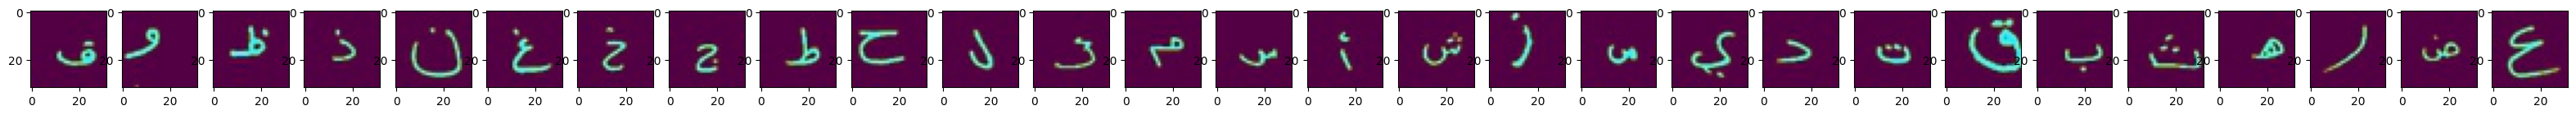

In [96]:
fig, ax = plt.subplots(1, 28, figsize=(40, 12))
for i,name in enumerate(set(train_df['label'])):
    sample = train_df[train_df['label'] == name].sample(1)
    image_path=sample['path'].item()
    X = cv2.imread(image_path)
    ax[i].imshow(X)

In [97]:
N = train_df.shape[0]
x_train = np.empty((N, 32, 32, 3), dtype=np.uint8)
for i, path in enumerate((train_df['path'])):
    x_train[i, :, :, :] = cv2.imread(path)

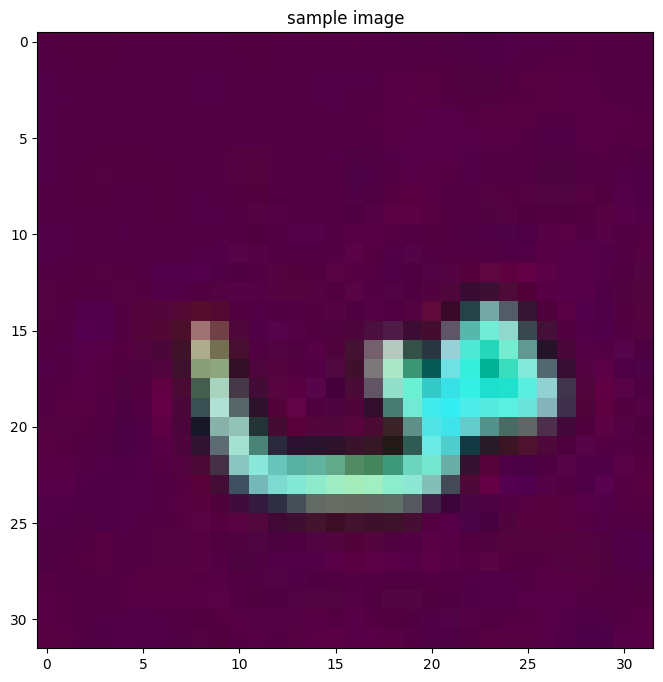

In [98]:
fig=plt.figure(figsize=(15, 8))
plt.title('sample image')
plt.imshow(x_train[5])

In [99]:
N = test_df.shape[0]
x_test = np.empty((N, 32, 32, 3), dtype=np.uint8)
for i, path in enumerate((test_df['path'])):
    x_test[i, :, :, :] = cv2.imread(path)

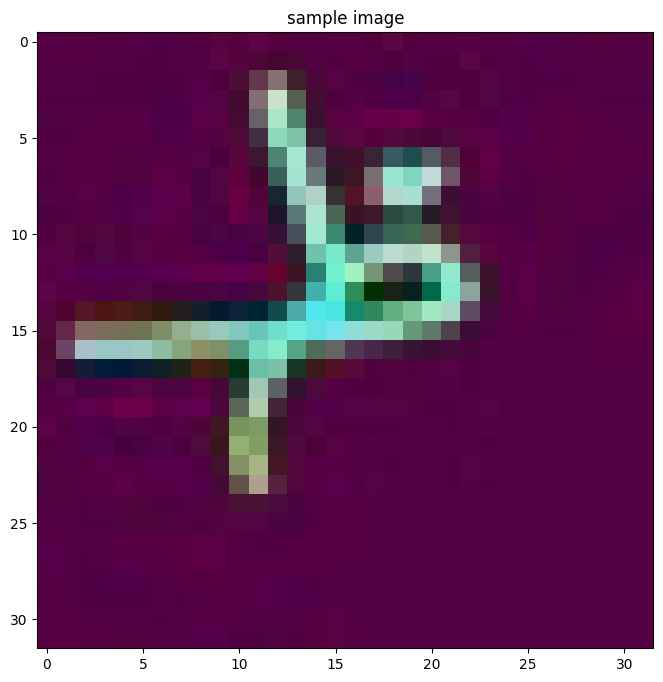

In [100]:
fig=plt.figure(figsize=(15, 8))
plt.title('sample image')
plt.imshow(x_test[5])

Converting Labels with the Label Encoder

In [101]:
lb=LabelEncoder()
y_train=lb.fit_transform(train_df['label'])

num_letters_in_arabic = 28
y_train=to_categorical(y_train, num_classes=num_letters_in_arabic)

In [102]:
y_test=lb.fit_transform(test_df['label'])

num_letters_in_arabic = 28
y_test=to_categorical(y_test, num_classes=num_letters_in_arabic)

Defining the Model Architecture

In [168]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import RMSprop

model = Sequential()

model.add(Conv2D(32, (3,3), padding='same', input_shape=(32, 32, 3), activation='relu'))
model.add(Conv2D(32, (3,3), activation='relu'))
model.add(Conv2D(32, (3,3), activation='relu'))
model.add(Dropout(0.4))
model.add(MaxPooling2D(2,2))
model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(Conv2D(64, (3,3), activation='relu'))

model.add(MaxPooling2D(2,2))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(28, activation='softmax'))


learning_rate = 0.001

optimizer = Adam(learning_rate=learning_rate)

model.compile(optimizer=optimizer,
                    loss='categorical_crossentropy',
                   metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=3, restore_best_weights=True)

In [169]:
model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_102 (Conv2D)         (None, 32, 32, 32)        896       
                                                                 
 conv2d_103 (Conv2D)         (None, 30, 30, 32)        9248      
                                                                 
 conv2d_104 (Conv2D)         (None, 28, 28, 32)        9248      
                                                                 
 dropout_30 (Dropout)        (None, 28, 28, 32)        0         
                                                                 
 max_pooling2d_34 (MaxPooli  (None, 14, 14, 32)        0         
 ng2D)                                                           
                                                                 
 batch_normalization_34 (Ba  (None, 14, 14, 32)        128       
 tchNormalization)                                   

In [170]:
history=model.fit(x_train, y_train,
                    validation_split=0.2,
                    callbacks=early_stopping,
                    epochs=50, batch_size=64, verbose=1)

Epoch 1/50
168/168 [==============================] - 5s 11ms/step - loss: 2.3780 - accuracy: 0.2993 - val_loss: 3.2664 - val_accuracy: 0.1659
Epoch 2/50
168/168 [==============================] - 2s 10ms/step - loss: 1.1496 - accuracy: 0.6204 - val_loss: 3.2722 - val_accuracy: 0.2630
Epoch 3/50
168/168 [==============================] - 2s 11ms/step - loss: 0.7097 - accuracy: 0.7706 - val_loss: 1.3636 - val_accuracy: 0.5443
Epoch 4/50
168/168 [==============================] - 2s 13ms/step - loss: 0.4973 - accuracy: 0.8422 - val_loss: 0.8026 - val_accuracy: 0.7381
Epoch 5/50
168/168 [==============================] - 2s 10ms/step - loss: 0.3818 - accuracy: 0.8795 - val_loss: 1.2621 - val_accuracy: 0.6068
Epoch 6/50
168/168 [==============================] - 2s 10ms/step - loss: 0.3167 - accuracy: 0.9022 - val_loss: 0.4986 - val_accuracy: 0.8490
Epoch 7/50
168/168 [==============================] - 2s 10ms/step - loss: 0.2708 - accuracy: 0.9132 - val_loss: 0.5428 - val_accuracy: 0.8318

Plotting the model's accuracies

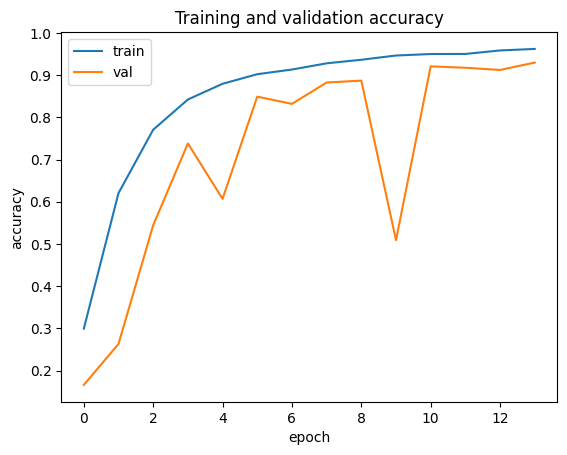

In [171]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

In [172]:
pred=model.predict(x_test)

105/105 [==============================] - 0s 2ms/step


In [173]:
loss, accuracy = model.evaluate(x_test,y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

105/105 [==============================] - 1s 5ms/step - loss: 0.2255 - accuracy: 0.9310
Test Loss: 0.22552558779716492
Test Accuracy: 0.9309523701667786


In [174]:
model.save('arabic_classifier.h5')

In [175]:
# prediction on first 10 images in test data
res=np.argmax(pred,axis=1)
res=lb.inverse_transform(res)
res[:10]

array(['beh', 'noon', 'yeh', 'feh', 'khah', 'zah', 'heh', 'dal', 'thal',
       'kaf'], dtype=object)

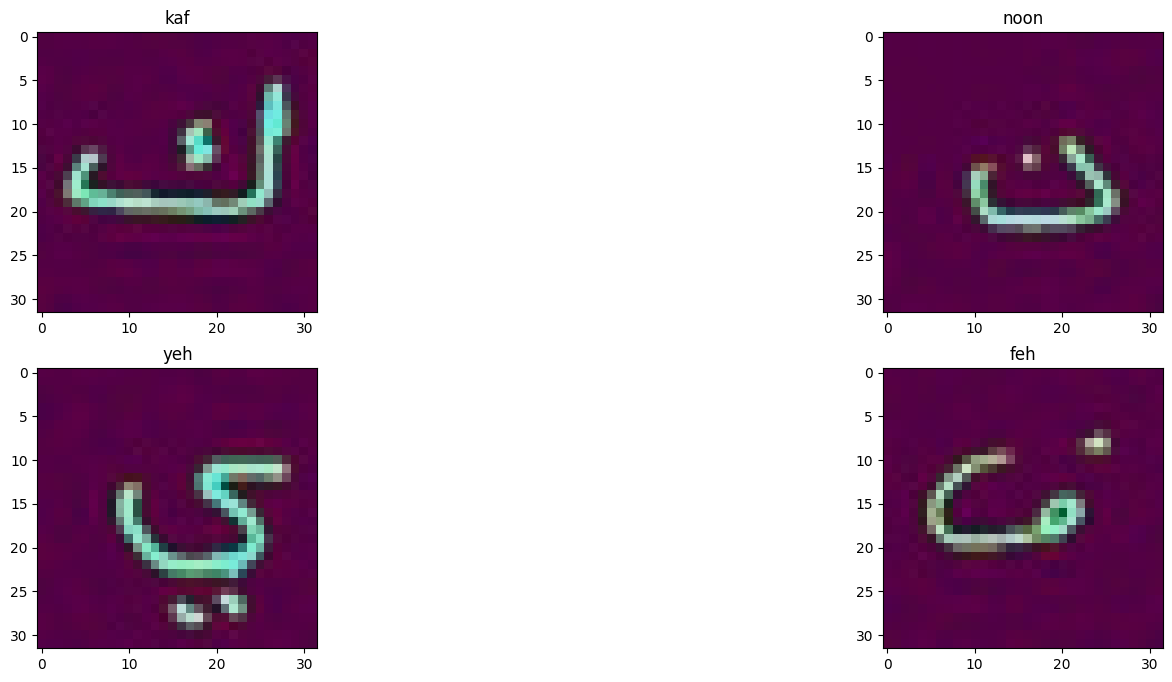

In [176]:
fig, axs = plt.subplots(2, 2,figsize=(20,8))
axs[0, 0].imshow(x_test[9])
axs[0, 0].set_title(res[9])
axs[0, 1].imshow(x_test[1])
axs[0, 1].set_title(res[1])
axs[1, 0].imshow(x_test[2])
axs[1, 0].set_title(res[2])
axs[1, 1].imshow(x_test[3])
axs[1, 1].set_title(res[3])
plt.show()